# Import

In [1]:
#!jupyter nbconvert --to script model_build.ipynb

import csv
import json
#import pywt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import neurokit2 as nk
from scipy.signal import butter, filtfilt
from scipy.signal import resample
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr, linregress
from sklearn.preprocessing import StandardScaler
import random
import tensorflow as tf
from tqdm.notebook import tqdm
from tensorflow.python.client import device_lib
import matplotlib.colors as mcolors
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, matthews_corrcoef
import tensorflow as tf
from imblearn.over_sampling import SMOTE



2024-09-23 00:41:00.852802: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-23 00:41:00.871532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 00:41:00.895325: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-23 00:41:00.895346: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-23 00:41:00.910570: I tensorflow/core/platform/cpu_feature_gua

In [2]:
print(tf.__version__)

2.16.2


In [3]:
tf.config.experimental.list_physical_devices('GPU')
device_lib.list_local_devices()

2024-09-23 00:41:09.136132: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:0 with 22757 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1b:00.0, compute capability: 7.5
2024-09-23 00:41:09.137789: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:1 with 22757 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:1c:00.0, compute capability: 7.5
2024-09-23 00:41:09.139203: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:2 with 22757 MB memory:  -> device: 2, name: Quadro RTX 6000, pci bus id: 0000:1d:00.0, compute capability: 7.5
2024-09-23 00:41:09.140366: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:3 with 22757 MB memory:  -> device: 3, name: Quadro RTX 6000, pci bus id: 0000:1e:00.0, compute capability: 7.5
2024-09-23 00:41:09.141447: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /dev

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13870152811207176969
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 23862837248
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 2
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 3
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 4
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 5
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 6
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 7
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 6771146940720615845
 physical_device_desc: "device: 0, name: Quadro RTX 6000, pci bus id: 0000:1b:00.0, compute capabi

In [4]:
MODEL_NAME = 'CNN_accuracy'
RUN = 'run17_' + MODEL_NAME+ '/'

CURRENT_DIR = os.getcwd()
DATA_DIR = CURRENT_DIR + '/data/'
MASTER_OUTPUT_DIR = CURRENT_DIR + '/output/'
OUTPUT_DIR = MASTER_OUTPUT_DIR + RUN
print(DATA_DIR)
print(OUTPUT_DIR)

/nfs/ada/jbrook1/users/qdang1/Descartes/Cognitive_battery_dissertation/data/
/nfs/ada/jbrook1/users/qdang1/Descartes/Cognitive_battery_dissertation/output/run17_CNN_accuracy/


In [5]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load data

In [6]:
# Initialize an empty list to store the arrays
X_dict = {}
Y_dict = {}

# Load each file and append the array to the list
for i in range(5):
    X_filename = f'X_fold{i}_accuracy.npy'
    X_dict[i] = np.load(DATA_DIR + X_filename, allow_pickle=True)

    Y_filename = f'Y_fold{i}_accuracy.npy'
    Y_dict[i] = np.load(DATA_DIR + Y_filename,  allow_pickle=True)

for i in range(5):
    print(f'i: {i}, X: {X_dict[i].shape}, Y: {Y_dict[i].shape}')


i: 0, X: (6665, 8), Y: (6665, 3)
i: 1, X: (6859, 8), Y: (6859, 3)
i: 2, X: (7025, 8), Y: (7025, 3)
i: 3, X: (6501, 8), Y: (6501, 3)
i: 4, X: (6514, 8), Y: (6514, 3)


In [7]:
for index in range(1):
    train_list = [0, 1, 2, 3, 4]
    train_list.remove(index)
    test_list = [index]

    print(f'train: {train_list}, test: {test_list}')

    X_train = X_dict[train_list[0]]
    Y_train = Y_dict[train_list[0]]
    X_test =  X_dict[test_list[0]]
    Y_test =  Y_dict[test_list[0]]
    
    for i_train in train_list[1:]:
        X_train = np.concatenate([X_train,X_dict[i_train] ],axis = 0)
        Y_train = np.concatenate([Y_train,Y_dict[i_train] ],axis = 0)

    for i_test in test_list[1:]:
        X_test = np.concatenate([X_test,X_dict[i_test] ],axis = 0)
        Y_test = np.concatenate([Y_test,Y_dict[i_test] ],axis = 0)

    print(f'X_train: {X_train.shape}, Y_train: {Y_train.shape}, X_test : {X_test.shape}, Y_test: {Y_test.shape}')

train: [1, 2, 3, 4], test: [0]
X_train: (26899, 8), Y_train: (26899, 3), X_test : (6665, 8), Y_test: (6665, 3)


In [8]:
X_train_demo          = np.array(X_train[:,0].tolist()).squeeze(1)
X_train_1_eye         = np.array(X_train[:,1].tolist())
X_train_1_eye_wavelet = np.array(X_train[:,2].tolist())
X_train_1_ecg         = np.array(X_train[:,3].tolist())
X_train_1_ecg_feature = np.array(X_train[:,4].tolist())
X_train_2_eye         = np.array(X_train[:,5].tolist())
X_train_2_ecg         = np.array(X_train[:,6].tolist())
X_train_2_ecg_feature = np.array(X_train[:,7].tolist())

# X_train_2_eye_mask    = np.array(X_train_2_eye[:,:,-4:])
# X_train_2_eye         = np.array(X_train_2_eye[:,:,:4])

# X_train_2_ecg_mask    = np.array(X_train_2_ecg[:,:,-1:])
# X_train_2_ecg         = np.array(X_train_2_ecg[:,:,:1])

# print(f'demo:          {X_train_demo.shape}\n\
# eye_1:         {X_train_1_eye.shape}\neye_1_wavelet: {X_train_1_eye_wavelet.shape}\n\
# ecg_1:         {X_train_1_ecg.shape}\necg_1_feature: {X_train_1_ecg_feature.shape}\n\
# eye_2:         {X_train_2_eye.shape}\neye_2_mask:    {X_train_2_eye_mask.shape}\n\
# ecg_2:         {X_train_2_ecg.shape}\necg_2_mask:    {X_train_2_ecg_mask.shape}\necg_2_feature: {X_train_2_ecg_feature.shape}\n')

print(f'demo:          {X_train_demo.shape}\n\
eye_1:         {X_train_1_eye.shape}\neye_1_wavelet: {X_train_1_eye_wavelet.shape}\n\
ecg_1:         {X_train_1_ecg.shape}\necg_1_feature: {X_train_1_ecg_feature.shape}\n\
eye_2:         {X_train_2_eye.shape}\n\
ecg_2:         {X_train_2_ecg.shape}\necg_2_feature: {X_train_2_ecg_feature.shape}\n')


demo:          (26899, 17)
eye_1:         (26899, 60000, 5)
eye_1_wavelet: (26899, 60000, 5)
ecg_1:         (26899, 60000, 1)
ecg_1_feature: (26899, 13)
eye_2:         (26899, 2500, 8)
ecg_2:         (26899, 2500, 2)
ecg_2_feature: (26899, 13)



In [9]:
Y_train_dif         = np.array(Y_train[:,0].tolist())
Y_train_acc         = np.array(Y_train[:,1].tolist())
Y_train_task        = np.array(Y_train[:,2].tolist())


print(f'Difficulty:       {Y_train_dif.shape}\nAccuracy:         {Y_train_acc.shape}\nTask:             {Y_train_task.shape}')

Difficulty:       (26899,)
Accuracy:         (26899,)
Task:             (26899,)


In [10]:
#filtering 
mask = (Y_train_task != 'task_switching')

X_train_demo          = X_train_demo[mask, :]
X_train_1_eye         = X_train_1_eye[mask, :, :]
X_train_1_eye_wavelet = X_train_1_eye_wavelet[mask, :, :]
X_train_1_ecg         = X_train_1_ecg[mask, :, :]
X_train_1_ecg_feature = X_train_1_ecg_feature[mask, :]
X_train_2_eye         = X_train_2_eye[mask, :, :]
# X_train_2_eye_mask    = X_train_2_eye_mask[mask, :, :]
X_train_2_ecg         = X_train_2_ecg[mask, :, :]
# X_train_2_ecg_mask    = X_train_2_ecg_mask[mask, :, :]
X_train_2_ecg_feature = X_train_2_ecg_feature[mask, :]


Y_train_dif         = Y_train_dif[mask]
Y_train_acc         = Y_train_acc[mask]
Y_train_task        = Y_train_task[mask]

print(f'demo:          {X_train_demo.shape}\n\
eye_1:         {X_train_1_eye.shape}\neye_1_wavelet: {X_train_1_eye_wavelet.shape}\n\
ecg_1:         {X_train_1_ecg.shape}\necg_1_feature: {X_train_1_ecg_feature.shape}\n\
eye_2:         {X_train_2_eye.shape}\n\
ecg_2:         {X_train_2_ecg.shape}\necg_2_feature: {X_train_2_ecg_feature.shape}\n')
print(f'Difficulty:       {Y_train_dif.shape}\nAccuracy:         {Y_train_acc.shape}\nTask:             {Y_train_task.shape}')

demo:          (8370, 17)
eye_1:         (8370, 60000, 5)
eye_1_wavelet: (8370, 60000, 5)
ecg_1:         (8370, 60000, 1)
ecg_1_feature: (8370, 13)
eye_2:         (8370, 2500, 8)
ecg_2:         (8370, 2500, 2)
ecg_2_feature: (8370, 13)

Difficulty:       (8370,)
Accuracy:         (8370,)
Task:             (8370,)


In [11]:
# #cliping with 99.5.5% 

# X_train_1_eye = np.clip(X_train_1_eye, np.percentile(X_train_1_eye, 0.5), np.percentile(X_train_1_eye, 99.5))
# X_train_1_eye_wavelet = np.clip(X_train_1_eye_wavelet, np.percentile(X_train_1_eye_wavelet, 0.5), np.percentile(X_train_1_eye_wavelet, 99.5))
# X_train_1_ecg = np.clip(X_train_1_ecg, np.percentile(X_train_1_ecg, 0.5), np.percentile(X_train_1_ecg, 99.5))
# X_train_1_ecg_feature = np.clip(X_train_1_ecg_feature, np.percentile(X_train_1_ecg_feature, 0.5), np.percentile(X_train_1_ecg_feature, 99.5))
# X_train_2_eye = np.clip(X_train_2_eye, np.percentile(X_train_2_eye, 0.5), np.percentile(X_train_2_eye, 99.5))
# #X_train_2_eye_wavelet = np.clip(X_train_2_eye_wavelet, np.percentile(X_train_2_eye_wavelet, 0.5), np.percentile(X_train_2_eye_wavelet, 99.5))
# X_train_2_ecg = np.clip(X_train_2_ecg, np.percentile(X_train_2_ecg, 0.5), np.percentile(X_train_2_ecg, 99.5))
# X_train_2_ecg_feature = np.clip(X_train_2_ecg_feature, np.percentile(X_train_2_ecg_feature, 0.5), np.percentile(X_train_2_ecg_feature, 99.5))

In [12]:
def smote_sampling(X, Y):

    smote = SMOTE(random_state=42)
    
    if len(X.shape) == 2:
        #2d array
        X_resampled, Y_resampled = smote.fit_resample(X, Y)
        
    elif len(X.shape) == 3:
        #3d array
        print("In 3d")
        n_samples, n_time, n_features = X.shape
        X = X.reshape(n_samples, -1) #convert from 3d to 2d
        
        X_resampled, Y_resampled = smote.fit_resample(X, Y)
        
        X_resampled = X_resampled.reshape(-1, n_time, n_features) #convert back to 3d

    return X_resampled, Y_resampled

In [13]:
# resampling
X_train_resampled, Y_train_resampled = smote_sampling(X_train_2_eye,Y_train_acc)

print(X_train_resampled.shape)
print(Y_train_resampled.shape)

print((Y_train_resampled == 0).sum())
print((Y_train_resampled == 1).sum())

In 3d
(11244, 2500, 8)
(11244,)
5622
5622


In [14]:
X_test_demo          = np.array(X_test[:,0].tolist()).squeeze(1)
X_test_1_eye         = np.array(X_test[:,1].tolist())
X_test_1_eye_wavelet = np.array(X_test[:,2].tolist())
X_test_1_ecg         = np.array(X_test[:,3].tolist())
X_test_1_ecg_feature = np.array(X_test[:,4].tolist())
X_test_2_eye         = np.array(X_test[:,5].tolist())
X_test_2_ecg         = np.array(X_test[:,6].tolist())
X_test_2_ecg_feature = np.array(X_test[:,7].tolist())

# X_test_2_eye_mask    = np.array(X_test_2_eye[:,:,-4:])
# X_test_2_eye         = np.array(X_test_2_eye[:,:,:4])

# X_test_2_ecg_mask    = np.array(X_test_2_ecg[:,:,-1:])
# X_test_2_ecg         = np.array(X_test_2_ecg[:,:,:1])


# print(f'demo:          {X_test_demo.shape}\n\
# eye_1:         {X_test_1_eye.shape}\neye_1_wavelet: {X_test_1_eye_wavelet.shape}\n\
# ecg_1:         {X_test_1_ecg.shape}\necg_1_feature: {X_test_1_ecg_feature.shape}\n\
# eye_2:         {X_test_2_eye.shape}\neye_2_mask:    {X_test_2_eye_mask.shape}\n\
# ecg_2:         {X_test_2_ecg.shape}\necg_2_mask:    {X_test_2_ecg_mask.shape}\necg_2_feature: {X_test_2_ecg_feature.shape}\n')

print(f'demo:          {X_test_demo.shape}\n\
eye_1:         {X_test_1_eye.shape}\neye_1_wavelet: {X_test_1_eye_wavelet.shape}\n\
ecg_1:         {X_test_1_ecg.shape}\necg_1_feature: {X_test_1_ecg_feature.shape}\n\
eye_2:         {X_test_2_eye.shape}\n\
ecg_2:         {X_test_2_ecg.shape}\necg_2_feature: {X_test_2_ecg_feature.shape}\n')

demo:          (6665, 17)
eye_1:         (6665, 60000, 5)
eye_1_wavelet: (6665, 60000, 5)
ecg_1:         (6665, 60000, 1)
ecg_1_feature: (6665, 13)
eye_2:         (6665, 2500, 8)
ecg_2:         (6665, 2500, 2)
ecg_2_feature: (6665, 13)



In [15]:
Y_test_dif         = np.array(Y_test[:,0].tolist())
Y_test_acc         = np.array(Y_test[:,1].tolist())
Y_test_task        = np.array(Y_test[:,2].tolist())

print(f'Difficulty:       {Y_test_dif.shape}\nAccuracy:         {Y_test_acc.shape}\nTask:             {Y_test_task.shape}')

Difficulty:       (6665,)
Accuracy:         (6665,)
Task:             (6665,)


In [16]:
mask = (Y_test_task != 'task_switching')

X_test_demo          = X_test_demo[mask, :]
X_test_1_eye         = X_test_1_eye[mask, :, :]
X_test_1_eye_wavelet = X_test_1_eye_wavelet[mask, :, :]
X_test_1_ecg         = X_test_1_ecg[mask, :, :]
X_test_1_ecg_feature = X_test_1_ecg_feature[mask, :]
X_test_2_eye         = X_test_2_eye[mask, :, :]
# X_test_2_eye_mask    = X_test_2_eye_mask[mask, :, :]
X_test_2_ecg         = X_test_2_ecg[mask, :, :]
# X_test_2_ecg_mask    = X_test_2_ecg_mask[mask, :, :]
X_test_2_ecg_feature = X_test_2_ecg_feature[mask, :]


Y_test_dif         = Y_test_dif[mask]
Y_test_acc         = Y_test_acc[mask]
Y_test_task        = Y_test_task[mask]



print(f'demo:          {X_test_demo.shape}\n\
eye_1:         {X_test_1_eye.shape}\neye_1_wavelet: {X_test_1_eye_wavelet.shape}\n\
ecg_1:         {X_test_1_ecg.shape}\necg_1_feature: {X_test_1_ecg_feature.shape}\n\
eye_2:         {X_test_2_eye.shape}\n\
ecg_2:         {X_test_2_ecg.shape}\necg_2_feature: {X_test_2_ecg_feature.shape}\n')
print(f'Difficulty:       {Y_test_dif.shape}\nAccuracy:         {Y_test_acc.shape}\nTask:             {Y_test_task.shape}')

demo:          (1981, 17)
eye_1:         (1981, 60000, 5)
eye_1_wavelet: (1981, 60000, 5)
ecg_1:         (1981, 60000, 1)
ecg_1_feature: (1981, 13)
eye_2:         (1981, 2500, 8)
ecg_2:         (1981, 2500, 2)
ecg_2_feature: (1981, 13)

Difficulty:       (1981,)
Accuracy:         (1981,)
Task:             (1981,)


In [17]:
# #cliping with 99.5% 

# X_test_1_eye = np.clip(X_test_1_eye, np.percentile(X_test_1_eye, 0.5), np.percentile(X_test_1_eye, 99.5))
# X_test_1_eye_wavelet = np.clip(X_test_1_eye_wavelet, np.percentile(X_test_1_eye_wavelet, 0.5), np.percentile(X_test_1_eye_wavelet, 99.5))
# X_test_1_ecg = np.clip(X_test_1_ecg, np.percentile(X_test_1_ecg, 0.5), np.percentile(X_test_1_ecg, 99.5))
# X_test_1_ecg_feature = np.clip(X_test_1_ecg_feature, np.percentile(X_test_1_ecg_feature, 0.5), np.percentile(X_test_1_ecg_feature, 99.5))
# X_test_2_eye = np.clip(X_test_2_eye, np.percentile(X_test_2_eye, 0.5), np.percentile(X_test_2_eye, 99.5))
# #X_test_2_eye_wavelet = np.clip(X_test_2_eye_wavelet, np.percentile(X_test_2_eye_wavelet, 0.5), np.percentile(X_test_2_eye_wavelet, 99.5))
# X_test_2_ecg = np.clip(X_test_2_ecg, np.percentile(X_test_2_ecg, 0.5), np.percentile(X_test_2_ecg, 99.5))
# X_test_2_ecg_feature = np.clip(X_test_2_ecg_feature, np.percentile(X_test_2_ecg_feature, 0.5), np.percentile(X_test_2_ecg_feature, 99.5))

In [18]:
# resampling
X_test_resampled, Y_test_resampled = smote_sampling(X_test_2_eye,Y_test_acc)

print(X_test_resampled.shape)
print(Y_test_resampled.shape)

print((Y_test_resampled == 0).sum())
print((Y_test_resampled == 1).sum())

In 3d
(2762, 2500, 8)
(2762,)
1381
1381


In [19]:

# print(np.isnan([X_train_demo]).any())
# print(np.isinf([X_train_demo]).any())
# print(np.isnan([X_train_1_eye]).any())
# print(np.isinf([X_train_1_eye]).any())
# print(np.isnan([X_train_1_eye_wavelet]).any())
# print(np.isinf([X_train_1_eye_wavelet]).any())
# print(np.isnan([X_train_1_ecg]).any())
# print(np.isinf([X_train_1_ecg]).any())
# print(np.isnan([X_train_1_ecg_feature]).any())
# print(np.isinf([X_train_1_ecg_feature]).any())

# print(np.isnan([X_train_2_eye]).any())
# print(np.isinf([X_train_2_eye]).any())
# print(np.isnan([X_train_2_ecg]).any())
# print(np.isinf([X_train_2_ecg]).any())
# print(np.isnan([X_train_2_ecg_feature]).any())
# print(np.isinf([X_train_2_ecg_feature]).any())

In [20]:
EPOCHS = 200
BATCH_SIZE = 16
PATIENCE = 20

# Build model. Eye sample Only

In [21]:
# Define the Transformer block with attention mask
def transformer_block(inputs, embed_dim, num_heads, ff_dim, dropout=0.2, mask=None):
    x = tf.keras.layers.MultiHeadAttention(key_dim=embed_dim, num_heads=num_heads, dropout=dropout)(inputs, inputs, inputs, attention_mask=mask)
    x = inputs + x
    res = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

    x = tf.keras.layers.Dense(ff_dim, activation="relu")(x)
    x = tf.keras.layers.Dense(embed_dim)(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = res + x
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x

In [22]:
# Define the model with attention mask
def build_model(input_shape, embed_dim, num_heads, ff_dim, dropout=0.2):
    inputs = tf.keras.layers.Input(shape=(input_shape[1], input_shape[2]), name='input_sample_eye')
    #mask   = tf.keras.layers.Input(shape=(input_shape[1], input_shape[2]), name='input_sample_eye_mask')  # Attention mask input

    sample_eye = tf.keras.layers.Dense(embed_dim)(inputs)
    sample_eye = transformer_block(sample_eye, embed_dim, num_heads, ff_dim, dropout)
    sample_eye = transformer_block(sample_eye, embed_dim, num_heads, ff_dim, dropout)
    sample_eye = transformer_block(sample_eye, embed_dim, num_heads, ff_dim, dropout)
    sample_eye = transformer_block(sample_eye, embed_dim, num_heads, ff_dim, dropout)
    sample_eye = transformer_block(sample_eye, embed_dim, num_heads, ff_dim, dropout)
    
    sample_eye = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first")(sample_eye)
    sample_eye = tf.keras.layers.Dense(128, activation="relu")(sample_eye)
    sample_eye = tf.keras.layers.Dropout(dropout)(sample_eye)
    sample_eye = tf.keras.layers.Dense(64, activation="relu")(sample_eye)
    sample_eye = tf.keras.layers.Dropout(dropout)(sample_eye)
    
    outputs    = tf.keras.layers.Dense(1, activation="sigmoid", name='accuracy')(sample_eye)

    
    model = tf.keras.Model(inputs, outputs)
    model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])
    
    return model
    




In [23]:
reduce_LR_On_Plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=PATIENCE//2,verbose=1, min_delta=0.00001,)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights = True, mode = 'min')

In [24]:
# Example usage
model = build_model(X_train_resampled.shape, embed_dim=64, num_heads=4, ff_dim=256, dropout=0.2)
model.summary()

2024-09-23 00:43:59.299420: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22757 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1b:00.0, compute capability: 7.5
2024-09-23 00:43:59.299919: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22757 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:1c:00.0, compute capability: 7.5
2024-09-23 00:43:59.300387: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22757 MB memory:  -> device: 2, name: Quadro RTX 6000, pci bus id: 0000:1d:00.0, compute capability: 7.5
2024-09-23 00:43:59.300829: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22757 MB memory:  -> device: 3, name: Quadro RTX 6000, pci bus id: 0000:1e:00.0, comp

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_sample_eye    │ (None, 2500, 8)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2500, 64)  │        576 │ input_sample_eye… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2500, 64)  │     66,368 │ dense[0][0],      │
│ (MultiHeadAttentio… │                   │            │ dense[0][0],      │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 2500, 64)  │          0 │ dense[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2500, 256) │     16,640 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2500, 64)  │     16,448 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 2500, 64)  │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2500, 64)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 2500, 64)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2500, 64)  │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2500, 64)  │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 2500, 64)  │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2500, 256) │     16,640 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 2500, 64)  │     16,448 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2500, 64)  │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 2500, 64)  │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 2500, 64)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2500, 64)  │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 827,585 (3.16 MB)

 Trainable params: 827,585 (3.16 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history =  model.fit([X_train_resampled], [Y_train_resampled], 
                    epochs=EPOCHS, batch_size=BATCH_SIZE,verbose=1, shuffle=True, validation_split = 0.2, callbacks=[reduce_LR_On_Plateau,early_stopping])

Epoch 1/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 216s 384ms/step - accuracy: 0.9056 - loss: 0.2152 - val_accuracy: 0.8235 - val_loss: 0.5226 - learning_rate: 1.2500e-05
Epoch 2/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 216s 384ms/step - accuracy: 0.9033 - loss: 0.2107 - val_accuracy: 0.8297 - val_loss: 0.5207 - learning_rate: 1.2500e-05
Epoch 3/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 216s 384ms/step - accuracy: 0.9065 - loss: 0.2006 - val_accuracy: 0.8204 - val_loss: 0.5664 - learning_rate: 1.2500e-05
Epoch 4/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 216s 384ms/step - accuracy: 0.9055 - loss: 0.1983 - val_accuracy: 0.8257 - val_loss: 0.5703 - learning_rate: 1.2500e-05
Epoch 5/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 216s 384ms/step - accuracy: 0.9030 - loss: 0.2002 - val_accuracy: 0.8301 - val_loss: 0.5733 - learning_rate: 1.2500e-05
Epoch 6/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 219s 389ms/step - accuracy: 0.9135 - loss: 0.1927 - val_accuracy: 0.8417 - val_loss: 0.5382 - learning_rate: 1.2500e-05
Epoch 7/200
563/563 ━━━━━━━━━━━━━━

In [35]:
model.save(OUTPUT_DIR + 'model.keras')

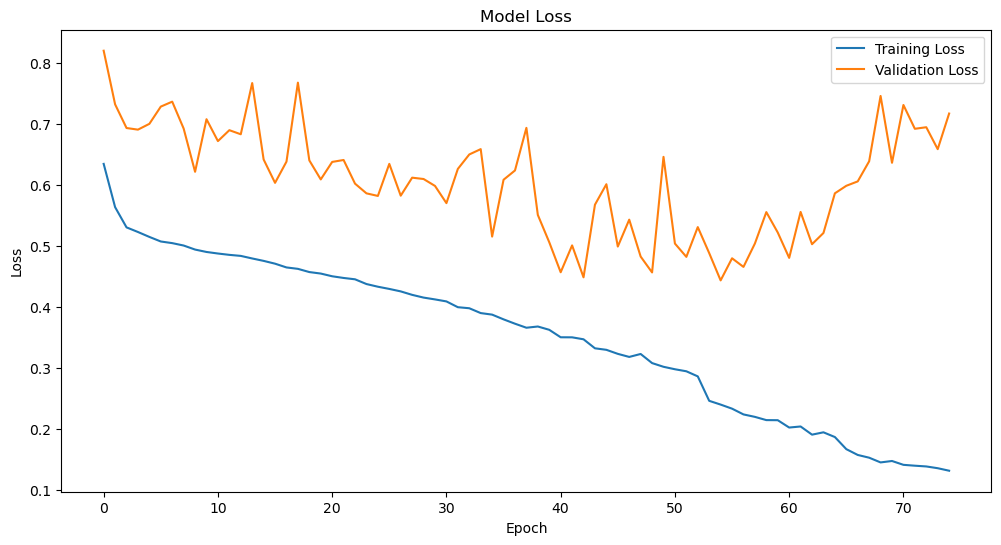

In [26]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(OUTPUT_DIR + 'Loss for model ecg')
plt.show()

In [27]:
def get_predict_label(predict_prob,threshold = 0.5):
    predict_label = []
    for y in predict_prob:
        if y <= threshold:
            predict_label.append(0)
        else:
            predict_label.append(1)
    
    return predict_label

In [28]:
Y_prob = model.predict([X_test_2_eye])


Y_pred = get_predict_label(Y_prob,threshold = 0.5)

I0000 00:00:1727085044.059858   81536 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_38', 8 bytes spill stores, 8 bytes spill loads



61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step

I0000 00:00:1727085072.612251   81582 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_38', 8 bytes spill stores, 8 bytes spill loads



62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 463ms/step


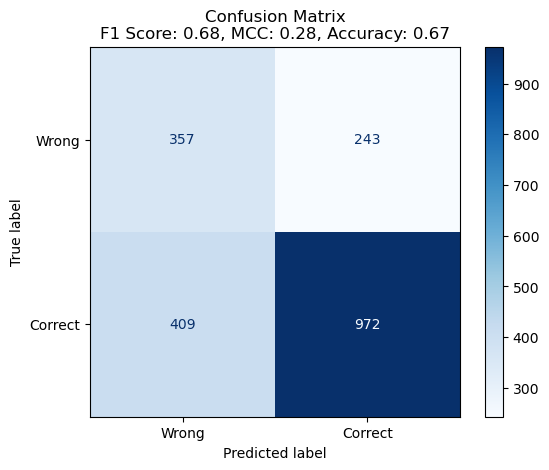

In [29]:
# Calculate the confusion matrix
cm = confusion_matrix(Y_test_acc, Y_pred)

f1 = f1_score(Y_test_acc,  Y_pred, average='weighted')
accuracy = accuracy_score(Y_test_acc,  Y_pred)
mcc = matthews_corrcoef(Y_test_acc,  Y_pred)

# Display the confusion matrix using Matplotlib
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix\nF1 Score: {f1:.2f}, MCC: {mcc:.2f}, Accuracy: {accuracy:.2f}")
plt.xticks([0,1],['Wrong','Correct'])
plt.yticks([0,1],['Wrong','Correct'])
plt.savefig(OUTPUT_DIR + 'Confusion Matrix for tranformer model.png')

plt.show()


/tmp/ipykernel_41727/65711152.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob_list[int(Y_test_acc[i])][int(Y_prob[i]*10)%10] += 1


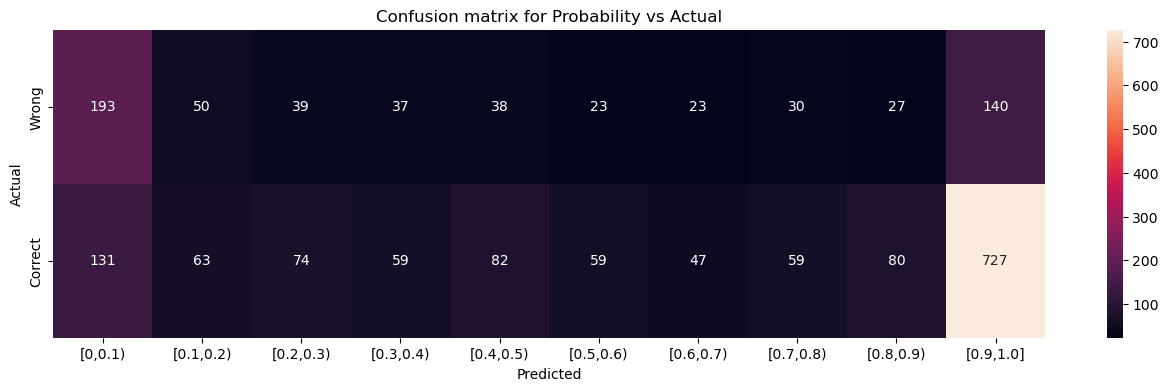

In [30]:
prob_list = np.zeros((2,10)) #first dimension is true_label, second dimension is probility.

#calculate the prob_list
for i in range(len(Y_prob)):
    #specical case
    if Y_prob[i] >= 1:
        prob_list[int(Y_test_acc[i])][9] += 1
    else:
        prob_list[int(Y_test_acc[i])][int(Y_prob[i]*10)%10] += 1

plt.figure(figsize=(16,4))
sns.heatmap(prob_list, annot=True,  fmt='.0f', yticklabels=['Wrong', 'Correct'], 
            xticklabels=['[0,0.1)', '[0.1,0.2)', '[0.2,0.3)', '[0.3,0.4)', '[0.4,0.5)', '[0.5,0.6)','[0.6,0.7)', '[0.7,0.8)', '[0.8,0.9)', '[0.9,1.0]'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion matrix for Probability vs Actual")
plt.savefig(OUTPUT_DIR+"/confusion_matrix_probability.png")
plt.show()

# Model_CNN

In [20]:
def custom_CNN_layer(input_layer, start_neuron = 16, kernel_size=9, strides_size=1, max_pool_size=5, dropout=0.3, padding='valid'):
    cnn_layer = tf.keras.layers.Conv1D(start_neuron, kernel_size, strides=strides_size,  padding=padding, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_layer)
    cnn_layer = tf.keras.layers.Conv1D(start_neuron, kernel_size, strides=strides_size,  padding=padding, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=tf.keras.regularizers.l2(0.01))(cnn_layer)
    cnn_layer = tf.keras.layers.MaxPool1D(max_pool_size,  padding=padding)(cnn_layer)
    cnn_layer = tf.keras.layers.BatchNormalization()(cnn_layer)
    cnn_layer = tf.keras.layers.Dropout(dropout)(cnn_layer)
    return cnn_layer

In [21]:
#create model
def baseline_merge(shape, start_neuron = 16, kernel_size_1 = 5, kernel_size_2 = 3 , strides_size=1, max_pool_size_1 = 3, max_pool_size_2 = 2 , dropout=0.3, padding='valid'):    

    input_demo                 = tf.keras.Input((shape[1],), name='input_demo') 
    input_baseline_eye         = tf.keras.Input((shape[3], shape[4]), name='input_baseline_eye') 
    input_baseline_wavelet     = tf.keras.Input((shape[6], shape[7]), name='input_baseline_eye_wavelet') 
    #input_baseline_ecg         = tf.keras.Input((shape[9], shape[10]), name='input_baseline_ecg')
    input_baseline_ecg_feature = tf.keras.Input((shape[12],), name='input_baseline_ecg_feature')
    
    input_sample_eye  = tf.keras.Input((shape[14], shape[15]), name='input_sample_eye') 
    input_sample_ecg = tf.keras.Input((shape[17], shape[18]), name='input_sample_ecg')
    input_sample_ecg_feature = tf.keras.Input((shape[20],), name='input_sample_ecg_feature')


    
    #baseline eye
    baseline_eye = custom_CNN_layer(input_baseline_eye, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    baseline_eye = custom_CNN_layer(baseline_eye, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    baseline_eye = custom_CNN_layer(baseline_eye, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    baseline_eye = custom_CNN_layer(baseline_eye, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    baseline_eye = custom_CNN_layer(baseline_eye, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)

    baseline_eye = custom_CNN_layer(baseline_eye, start_neuron * 2, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    baseline_eye = custom_CNN_layer(baseline_eye, start_neuron * 2, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    baseline_eye = custom_CNN_layer(baseline_eye, start_neuron * 2, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    baseline_eye = custom_CNN_layer(baseline_eye, start_neuron * 2, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    baseline_eye = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(baseline_eye)
    baseline_eye = tf.keras.layers.Dropout(dropout)(baseline_eye)
    baseline_eye = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(baseline_eye)
    baseline_eye = tf.keras.layers.Dropout(dropout)(baseline_eye)
    baseline_eye = tf.keras.layers.Flatten()(baseline_eye)
    #baseline_eye = tf.keras.layers.Dense(start_neuron * 4)(baseline_eye)

    
    # Baseline
    # baseline_ecg = custom_CNN_layer(input_baseline_ecg, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    # baseline_ecg = custom_CNN_layer(baseline_ecg, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    # baseline_ecg = custom_CNN_layer(baseline_ecg, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    # baseline_ecg = custom_CNN_layer(baseline_ecg, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    # baseline_ecg = custom_CNN_layer(baseline_ecg, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)

    # baseline_ecg = custom_CNN_layer(baseline_ecg, start_neuron * 2, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    # baseline_ecg = custom_CNN_layer(baseline_ecg, start_neuron * 2, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    # baseline_ecg = custom_CNN_layer(baseline_ecg, start_neuron * 2, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    # baseline_ecg = custom_CNN_layer(baseline_ecg, start_neuron * 2, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    # baseline_ecg = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(baseline_ecg)
    # baseline_ecg = tf.keras.layers.Dropout(dropout)(baseline_ecg)
    # baseline_ecg = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(baseline_ecg)
    # baseline_ecg = tf.keras.layers.Dropout(dropout)(baseline_ecg)
    # baseline_ecg = tf.keras.layers.Flatten()(baseline_ecg)
    # #baseline_ecg = tf.keras.layers.Dense(start_neuron * 4)(baseline_ecg)
  
    
    #samples_eye
    sample_eye  = custom_CNN_layer(input_sample_eye, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    sample_eye  = custom_CNN_layer(sample_eye, start_neuron , kernel_size =  kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    sample_eye  = custom_CNN_layer(sample_eye, start_neuron , kernel_size =  kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    sample_eye  = custom_CNN_layer(sample_eye, start_neuron * 2, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    sample_eye  = custom_CNN_layer(sample_eye, start_neuron * 4, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    sample_eye  = custom_CNN_layer(sample_eye, start_neuron * 4, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    sample_eye = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(sample_eye)
    sample_eye = tf.keras.layers.Dropout(dropout)(sample_eye)
    sample_eye = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(sample_eye)
    sample_eye = tf.keras.layers.Dropout(dropout)(sample_eye)
    sample_eye = tf.keras.layers.Flatten()(sample_eye)
    

    # Samples_ecg
    sample_ecg  = custom_CNN_layer(input_sample_ecg, start_neuron, kernel_size = kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    sample_ecg  = custom_CNN_layer(sample_ecg, start_neuron , kernel_size =  kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    sample_ecg  = custom_CNN_layer(sample_ecg, start_neuron , kernel_size =  kernel_size_1, strides_size=strides_size, max_pool_size=max_pool_size_1, dropout=dropout, padding=padding)
    sample_ecg  = custom_CNN_layer(sample_ecg, start_neuron * 2, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    sample_ecg  = custom_CNN_layer(sample_ecg, start_neuron * 4, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    sample_ecg  = custom_CNN_layer(sample_ecg, start_neuron * 4, kernel_size = kernel_size_2, strides_size=strides_size, max_pool_size=max_pool_size_2, dropout=dropout, padding=padding)
    sample_ecg = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(sample_ecg)
    sample_ecg = tf.keras.layers.Dropout(dropout)(sample_ecg)
    sample_ecg = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(sample_ecg)
    sample_ecg = tf.keras.layers.Dropout(dropout)(sample_ecg)
    sample_ecg = tf.keras.layers.Flatten()(sample_ecg)


    
    concat_layer = tf.keras.layers.Concatenate()([baseline_eye, sample_eye,sample_ecg, input_demo, input_baseline_ecg_feature, input_sample_ecg_feature])
    output_layer = tf.keras.layers.Dense(start_neuron*4,activation=tf.keras.layers.LeakyReLU())(concat_layer)
    output_layer = tf.keras.layers.Dropout(dropout)(output_layer)
    output_layer = tf.keras.layers.Dense(start_neuron*8,activation=tf.keras.layers.LeakyReLU())(output_layer)
    output_layer = tf.keras.layers.Dropout(dropout)(output_layer)
    #output_0 = tf.keras.layers.Dense(3, activation='softmax', name='difficulty')(output_layer)
    output_0 = tf.keras.layers.Dense(1, activation='sigmoid', name='accuracy')(output_layer)
    #baseline_eye_wavelet, 
    
    model = tf.keras.Model(inputs=[input_demo, input_baseline_eye, input_baseline_ecg_feature,\
                                   input_sample_eye, input_sample_ecg, input_sample_ecg_feature], outputs=[output_0])
    
    #model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [22]:
current_shape = X_train_demo.shape + X_train_1_eye.shape + X_train_1_eye_wavelet.shape + X_train_1_ecg.shape + X_train_1_ecg_feature.shape \
+ X_train_2_eye.shape + X_train_2_ecg.shape + X_train_2_ecg_feature.shape

current_shape

(8370,
 17,
 8370,
 60000,
 5,
 8370,
 60000,
 5,
 8370,
 60000,
 1,
 8370,
 13,
 8370,
 2500,
 4,
 8370,
 2500,
 1,
 8370,
 13)

In [23]:
reduce_LR_On_Plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=PATIENCE//2,verbose=1, min_delta=0.00001,)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights = True, mode = 'min')

In [24]:
#model_merge = baseline_merge(current_shape, start_neuron=16)
model_merge = baseline_merge(current_shape, start_neuron=16, kernel_size_1 = 5, kernel_size_2 = 3 , strides_size= 1, max_pool_size_1 = 3, max_pool_size_2 = 2 , dropout=0.2, padding='same')
model_merge.summary()

# history = model_merge.fit([X_train_demo, X_train_1_eye, X_train_1_eye_wavelet, X_train_1_ecg, X_train_1_ecg_feature,\
#                          X_train_2_eye,X_train_2_ecg, X_train_2_ecg_feature], [Y_train_dif], 
#                     epochs=EPOCHS, batch_size=BATCH_SIZE,verbose=1, shuffle=True, validation_split = 0.2, callbacks=[reduce_LR_On_Plateau,early_stopping])



2024-09-19 15:54:13.848411: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22757 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1b:00.0, compute capability: 7.5
2024-09-19 15:54:13.849096: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22757 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:1c:00.0, compute capability: 7.5
2024-09-19 15:54:13.849735: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22757 MB memory:  -> device: 2, name: Quadro RTX 6000, pci bus id: 0000:1d:00.0, compute capability: 7.5
2024-09-19 15:54:13.850369: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22757 MB memory:  -> device: 3, name: Quadro RTX 6000, pci bus id: 0000:1e:00.0, comp

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_baseline_eye  │ (None, 60000, 5)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 60000, 16) │        416 │ input_baseline_e… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 60000, 16) │      1,296 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 20000, 16) │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 20000, 16) │         64 │ max_pooling1d[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 20000, 16) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 20000, 16) │      1,296 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 20000, 16) │      1,296 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 6667, 16)  │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6667, 16)  │         64 │ max_pooling1d_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 6667, 16)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 6667, 16)  │      1,296 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 6667, 16)  │      1,296 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 2223, 16)  │          0 │ conv1d_5[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2223, 16)  │         64 │ max_pooling1d_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2223, 16)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_sample_eye    │ (None, 2500, 4)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_sample_ecg    │ (None, 2500, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 2223, 16)  │      1,296 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 2500, 16)  │        336 │ input_sample_eye… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 463,041 (1.77 MB)

 Trainable params: 461,793 (1.76 MB)

 Non-trainable params: 1,248 (4.88 KB)

In [25]:
history = model_merge.fit([X_train_demo, X_train_1_eye, X_train_1_ecg_feature,\
                         X_train_2_eye,X_train_2_ecg, X_train_2_ecg_feature], [Y_train_acc], 
                    epochs=EPOCHS, batch_size=BATCH_SIZE,verbose=1, shuffle=True, validation_split = 0.2, callbacks=[reduce_LR_On_Plateau,early_stopping])

Epoch 1/200


2024-09-19 15:55:14.896122: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


419/419 ━━━━━━━━━━━━━━━━━━━━ 173s 81ms/step - accuracy: 0.6775 - loss: 6.4210 - val_accuracy: 0.6159 - val_loss: 1.1506 - learning_rate: 0.0010
Epoch 2/200
419/419 ━━━━━━━━━━━━━━━━━━━━ 85s 66ms/step - accuracy: 0.7428 - loss: 0.8646 - val_accuracy: 0.7049 - val_loss: 0.6637 - learning_rate: 0.0010
Epoch 3/200
419/419 ━━━━━━━━━━━━━━━━━━━━ 27s 64ms/step - accuracy: 0.7419 - loss: 0.5925 - val_accuracy: 0.6720 - val_loss: 0.6290 - learning_rate: 0.0010
Epoch 4/200
419/419 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.7500 - loss: 0.5545 - val_accuracy: 0.6959 - val_loss: 0.6541 - learning_rate: 0.0010
Epoch 5/200
419/419 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - accuracy: 0.7558 - loss: 0.5515 - val_accuracy: 0.6607 - val_loss: 0.7091 - learning_rate: 0.0010
Epoch 6/200
419/419 ━━━━━━━━━━━━━━━━━━━━ 28s 66ms/step - accuracy: 0.7511 - loss: 0.5482 - val_accuracy: 0.7007 - val_loss: 0.6215 - learning_rate: 0.0010
Epoch 7/200
419/419 ━━━━━━━━━━━━━━━━━━━━ 27s 65ms/step - accuracy: 0.7533 - loss:

In [26]:
def get_predict_label(predict_prob,threshold = 0.5):
    predict_label = []
    for y in predict_prob:
        if y <= threshold:
            predict_label.append(0)
        else:
            predict_label.append(1)
    
    return predict_label

In [28]:
# Y_pred = model_merge.predict([X_test_demo, X_test_1_eye, X_test_1_eye_wavelet, X_test_1_ecg, X_test_1_ecg_feature,\
#                          X_test_2_eye,X_test_2_ecg, X_test_2_ecg_feature])
Y_prob = model_merge.predict([X_test_demo, X_test_1_eye, X_test_1_ecg_feature,\
                         X_test_2_eye,X_test_2_ecg, X_test_2_ecg_feature])


Y_pred = get_predict_label(Y_prob,threshold = 0.5)

62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step


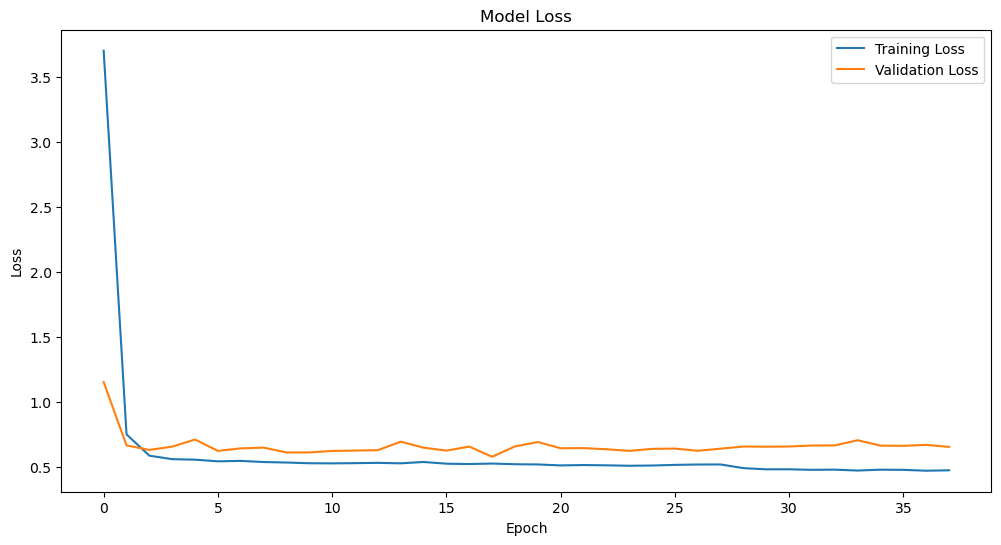

In [29]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(OUTPUT_DIR + 'Loss for model_merge')
plt.show()

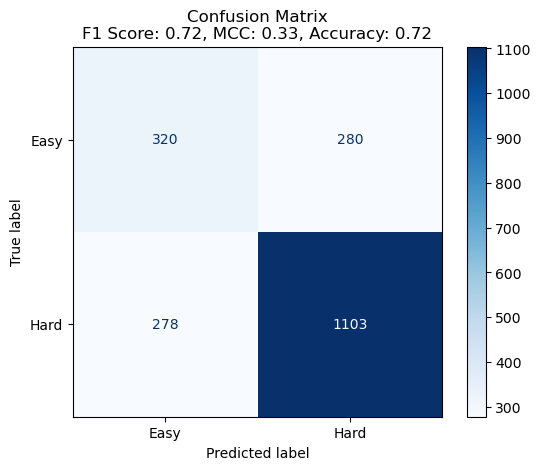

In [30]:
# Calculate the confusion matrix
cm = confusion_matrix(Y_test_acc, Y_pred)

f1 = f1_score(Y_test_acc,  Y_pred, average='weighted')
accuracy = accuracy_score(Y_test_acc,  Y_pred)
mcc = matthews_corrcoef(Y_test_acc,  Y_pred)

# Display the confusion matrix using Matplotlib
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix\nF1 Score: {f1:.2f}, MCC: {mcc:.2f}, Accuracy: {accuracy:.2f}")
plt.xticks([0,1],['Easy','Hard'])
plt.yticks([0,1],['Easy','Hard'])
plt.savefig(OUTPUT_DIR + 'Confusion Matrix for model_merge')

plt.show()


/tmp/ipykernel_165805/4069847126.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob_list[int(Y_test_acc[i])][int(Y_prob[i]*10)%10] += 1


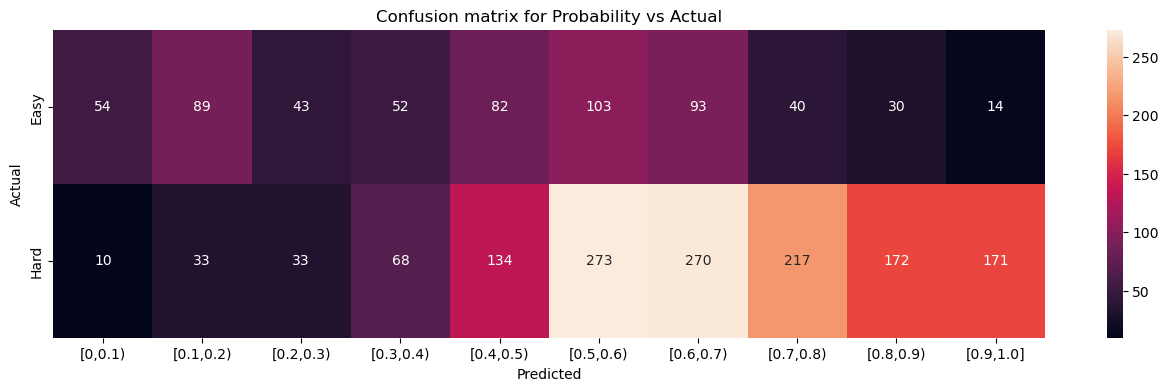

In [35]:
prob_list = np.zeros((2,10)) #first dimension is true_label, second dimension is probility.

#calculate the prob_list
for i in range(len(Y_prob)):
    #specical case
    if Y_prob[i] >= 1:
        prob_list[int(Y_test_acc[i])][9] += 1
    else:
        prob_list[int(Y_test_acc[i])][int(Y_prob[i]*10)%10] += 1

plt.figure(figsize=(16,4))
sns.heatmap(prob_list, annot=True,  fmt='.0f', yticklabels=['Easy', 'Hard'], 
            xticklabels=['[0,0.1)', '[0.1,0.2)', '[0.2,0.3)', '[0.3,0.4)', '[0.4,0.5)', '[0.5,0.6)','[0.6,0.7)', '[0.7,0.8)', '[0.8,0.9)', '[0.9,1.0]'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion matrix for Probability vs Actual")
plt.savefig(OUTPUT_DIR+"/confusion_matrix_probability.png")
plt.show()

In [34]:
Y_test_acc[i]

0.0